# Set up

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 10)
import matplotlib.pyplot as plt
import seaborn as sb
import missingno as msno

In [2]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split

In [3]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier

In [35]:
def show_confusion_matrix(labels_test, labels_predicted, labels = None):
    plt.figure(figsize = (10, 7))
    cm = confusion_matrix(labels_test, labels_predicted)
    if labels != None:
        sb.heatmap(
            cm,
            annot = True,
            fmt = 'd',
            cbar = False,
            xticklabels = labels,
            yticklabels = labels)
    else:
        sb.heatmap(
            cm,
            annot = True,
            fmt = 'd',
            cbar = False)
    plt.xlabel('Predicted')
    plt.ylabel('Truth')
    plt.show()

In [36]:
def show_training_history(history, last_epoch = None):
    fig, ax = plt.subplots(2, 1)
    ax[0].plot(history.history['loss'], color = 'b', label = 'Training loss')
    if 'val_loss' in history.history:
        ax[0].plot(history.history['val_loss'], color = 'r', label = 'Validation loss', axes = ax[0])
    if last_epoch is not None:
        ax[0].axvline(x = last_epoch, color = 'g', label = 'Start of fine tuning')
    legend = ax[0].legend(loc = 'best', shadow = True)
    ax[1].plot(history.history['accuracy'], color = 'b', label = 'Training accuracy')
    if 'val_accuracy' in history.history:
        ax[1].plot(history.history['val_accuracy'], color = 'r',label = 'Validation accuracy')
    if last_epoch is not None:
        ax[1].axvline(x = last_epoch, color = 'g', label = 'Start of fine tuning')
    legend = ax[1].legend(loc = 'best', shadow = True)
    plt.show()

# Dataset

In [4]:
ds = pd.read_csv('Synthetic_Dataset.csv')
ds

x01         x02         x03         x04        x05  ...  \
0        69.659807 -102.567490 -209.903964    6.472164   4.313487  ...   
1      -167.101860  -10.358355 -245.384592  -40.677900   0.273391  ...   
2        13.336421  -95.034657  -14.315424  220.731440  -0.768787  ...   
3       -22.264600 -104.296800   76.000002  -41.293515 -10.132445  ...   
4       -48.277153   44.170234  165.491114   72.755204   4.191435  ...   
...            ...         ...         ...         ...        ...  ...   
119995   69.019243   69.678800  -43.927496 -189.412705  -6.873485  ...   
119996  -56.719397   26.530471 -253.238920  104.530108   5.664701  ...   
119997  -12.006466  -67.594048  -57.671303 -246.153987  -8.788019  ...   
119998  -73.004201 -158.295355 -249.423123  -28.372124  -1.720927  ...   
119999 -124.638808  -14.661764  100.334294 -154.745470 -12.930240  ...   

               x07         x08         x09         x10  class  
0        -2.332122 -162.011126  157.151007   26.729849      0  
1       -88.687790  -31.520900  -49.678909   -6.353039      0  
2       -10.678075   64.526753 -105.345817  108.155193      1  
3        33.234002  -70.546114   -4.324115  -83.161245      1  
4        -7.188119  252.577423   41.923064 -102.622804      1  
...            ...         ...         ...         ...    ...  
119995  -38.601989 -102.568423   58.869594   63.136282      2  
119996 -104.254184   42.196204  133.678476  161.542990      0  
119997  -16.214359 -138.868499  -90.248863 -158.980527      1  
119998   20.457649 -279.423463   50.368413  -30.839177      0  
119999   32.128549  -95.692053  107.798074 -117.254300      1  

[120000 rows x 11 columns]

## Dataset lookup

In [42]:
def dataset_lookup(df):
    print('Dataset info:')
    print(df.info())
    print()
    print('Dataset description:')
    print(df.describe())
    print()
    print('Amount of duplicates:')
    duplicates_amount = df.duplicated().sum()
    print(duplicates_amount)
    if (duplicates_amount > 0):
        print('Duplicates:')
        print(df[df.duplicated()])
    print()
    print('Amount of missing values:')
    print(df.isna().sum(axis = 0))
    print()
    print('Unique values in each column:')
    object_types_count = 0
    for column in df:
        if df[column].dtypes == 'object':
            object_types_count += 1
            print('-' * len(column))
            print(f'{column}: {df[column].unique()}')
    if object_types_count == 0:
        print('-' * 10)
        print('No object columns in this dataset.')
            
dataset_lookup(ds)

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120000 entries, 0 to 119999
Data columns (total 11 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   x01     120000 non-null  float64
 1   x02     120000 non-null  float64
 2   x03     120000 non-null  float64
 3   x04     120000 non-null  float64
 4   x05     120000 non-null  float64
 5   x06     120000 non-null  float64
 6   x07     120000 non-null  float64
 7   x08     120000 non-null  float64
 8   x09     120000 non-null  float64
 9   x10     120000 non-null  float64
 10  class   120000 non-null  int64  
dtypes: float64(10), int64(1)
memory usage: 10.1 MB
None

Dataset description:
                 x01            x02            x03            x04  \
count  120000.000000  120000.000000  120000.000000  120000.000000   
mean        0.271058     -24.791797      -3.819406      51.160051   
std       139.907581      78.745093     206.262940     192.503240   
min      -564.102614    -3

## Dataset showcase

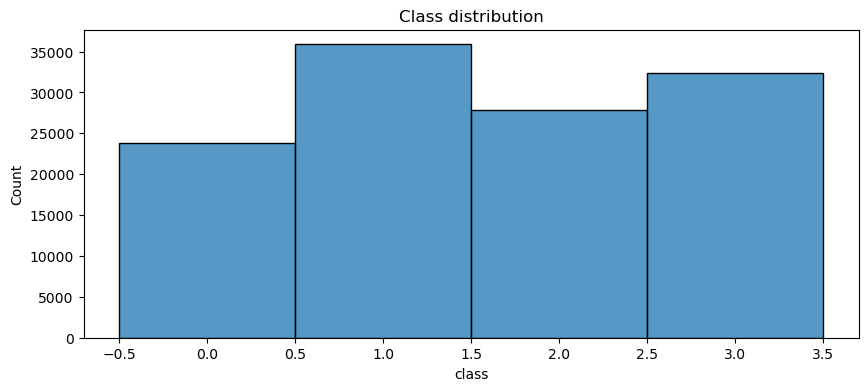

In [5]:
def show_class_distribution(y, encoder = None):
    plt.figure(figsize = (10, 4))
    plt.title('Class distribution')
    if encoder != None:
        sb.histplot(encoder.inverse_transform(y), discrete = True)
    else:
        sb.histplot(y, discrete = True)
    plt.show()
    
show_class_distribution(ds['class'])

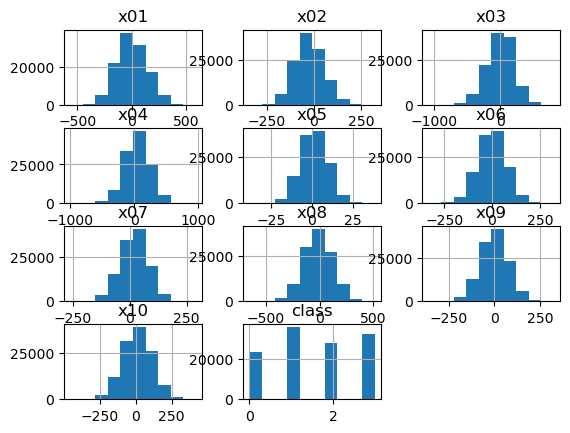

In [14]:
def plot_dataset_histograms(df):
    df.hist()
    plt.show()

plot_dataset_histograms(ds)

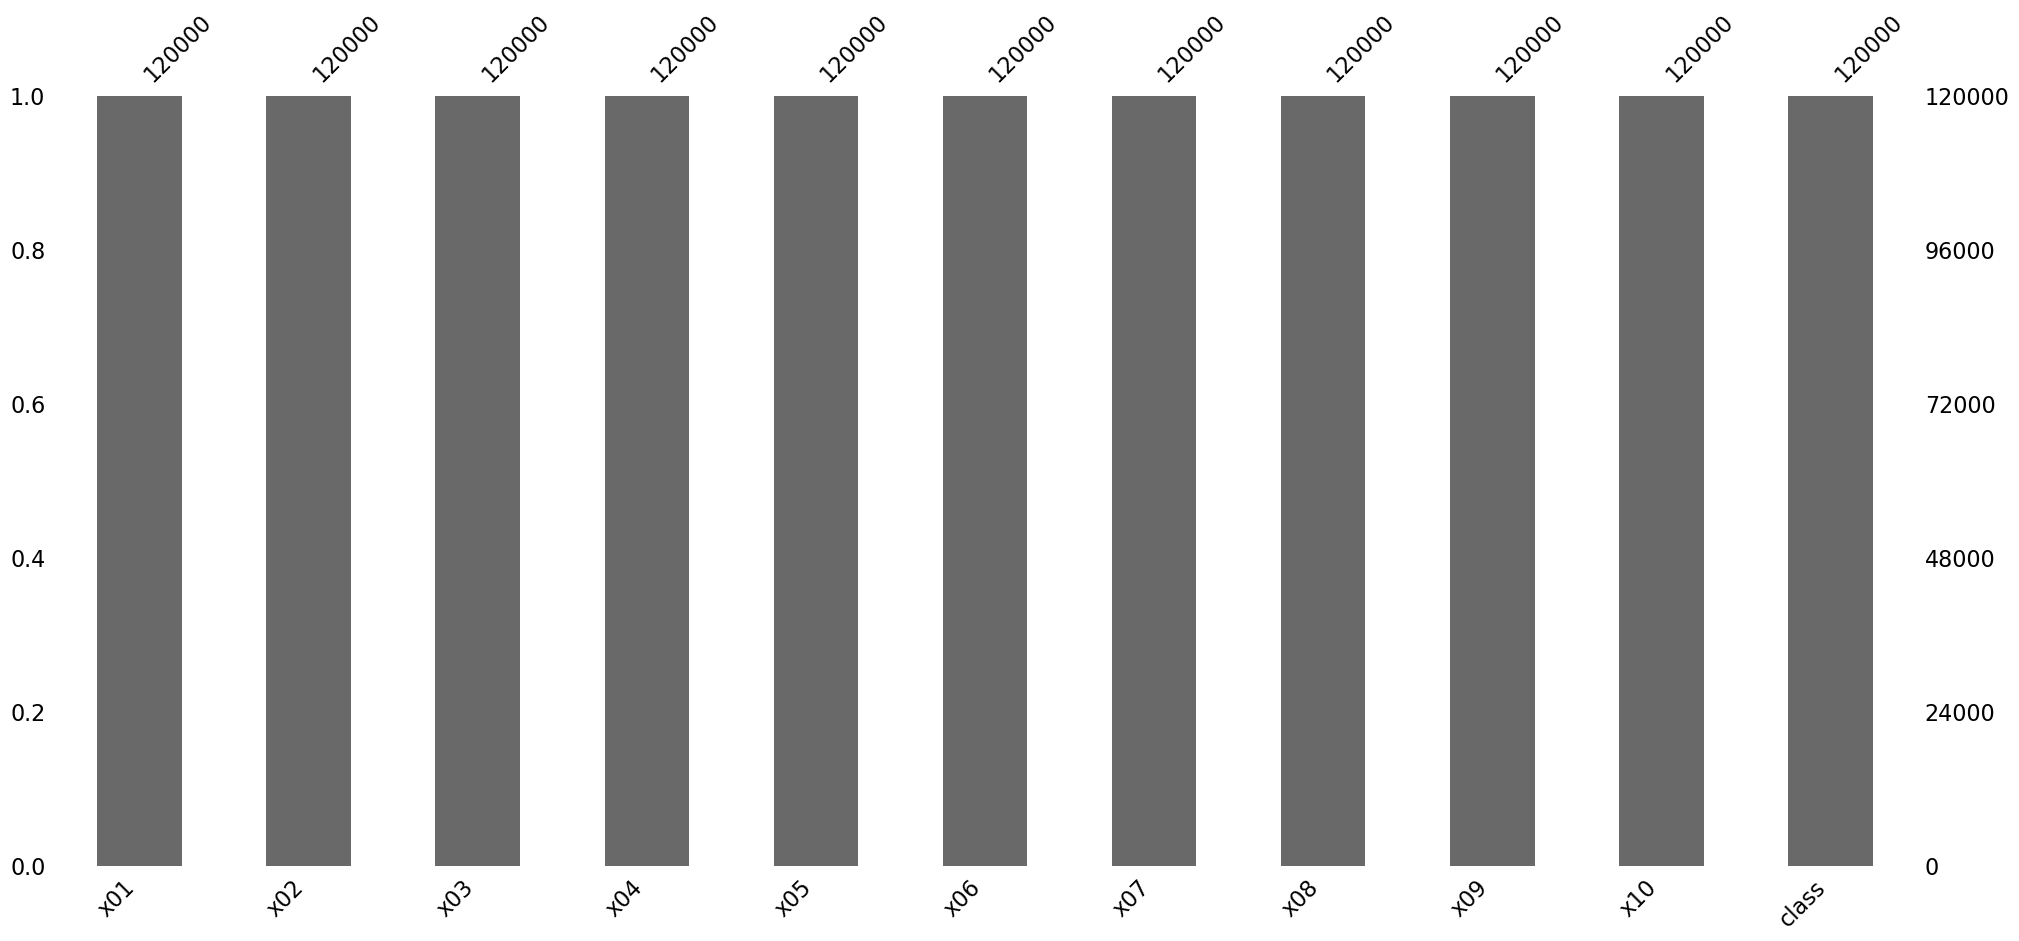

In [8]:
msno.bar(ds)
plt.show()

<Figure size 1500x1500 with 0 Axes>

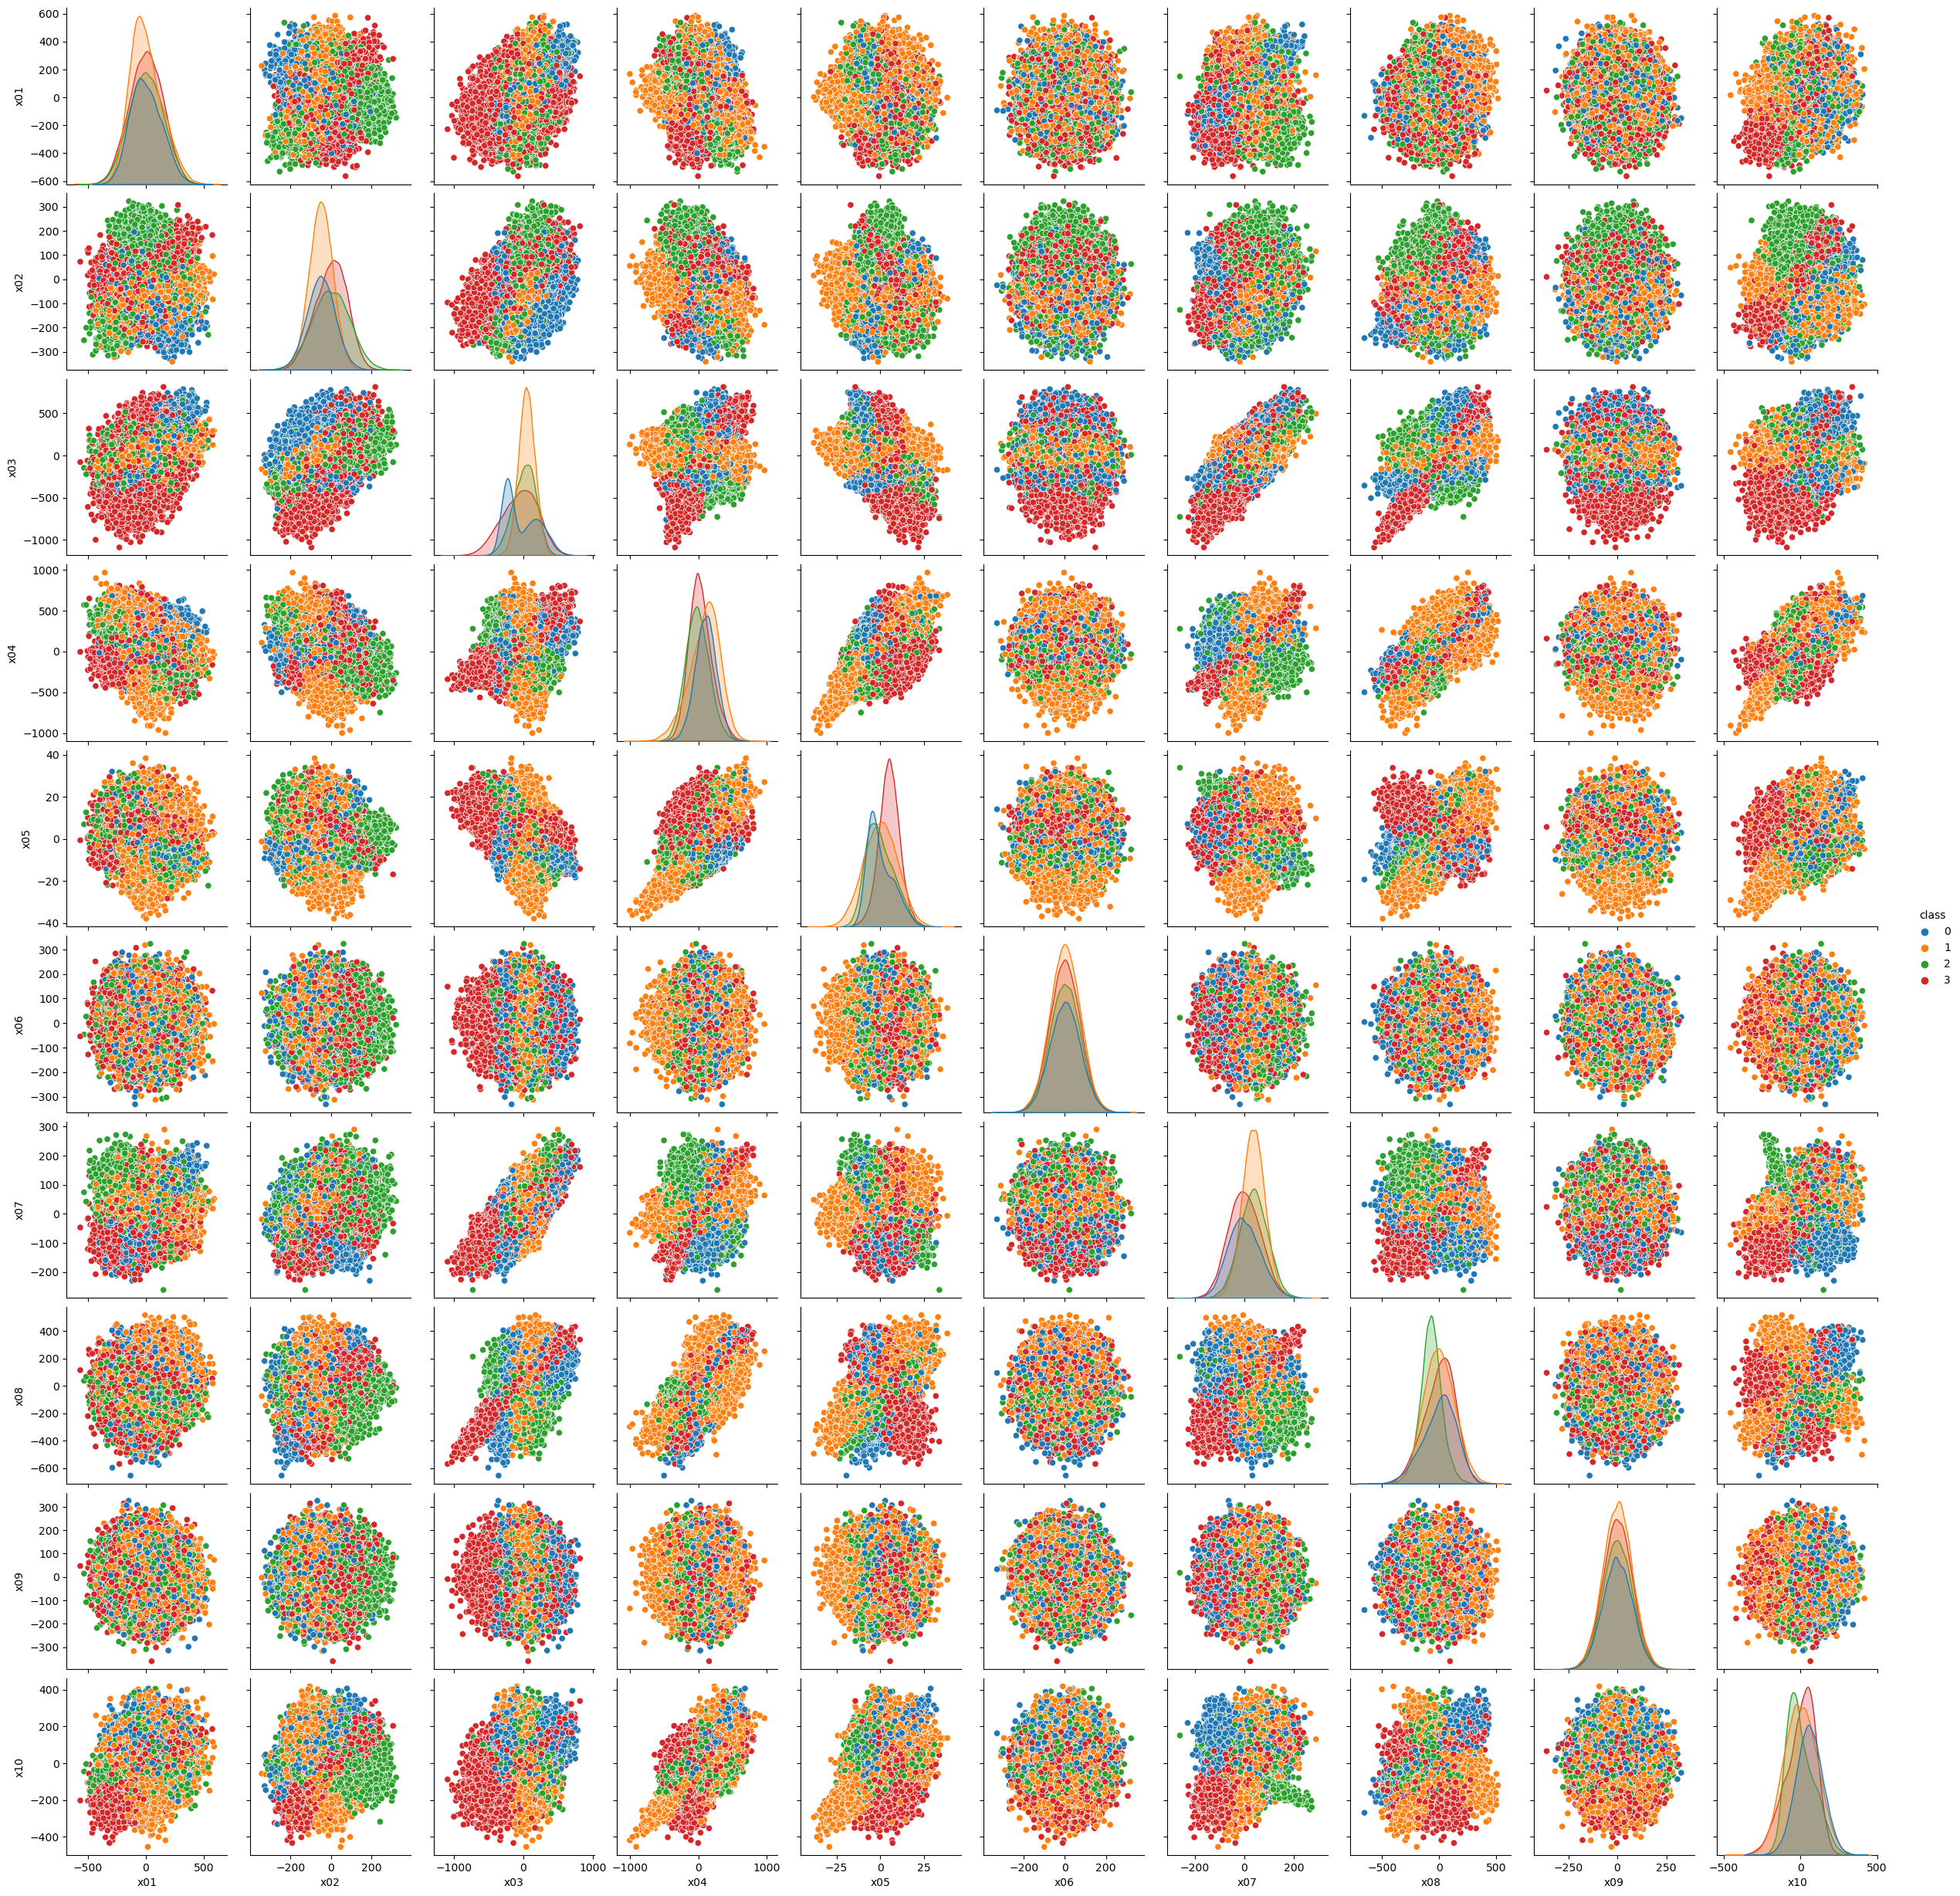

In [20]:
def show_pair_plot(df, figure_size = (15, 15), target_name = None):
    plt.figure(figsize = figure_size)
    sb.pairplot(df.select_dtypes(exclude = ['object']), palette = 'tab10', hue = target_name)
    plt.show()
    
show_pair_plot(ds, target_name = 'class')

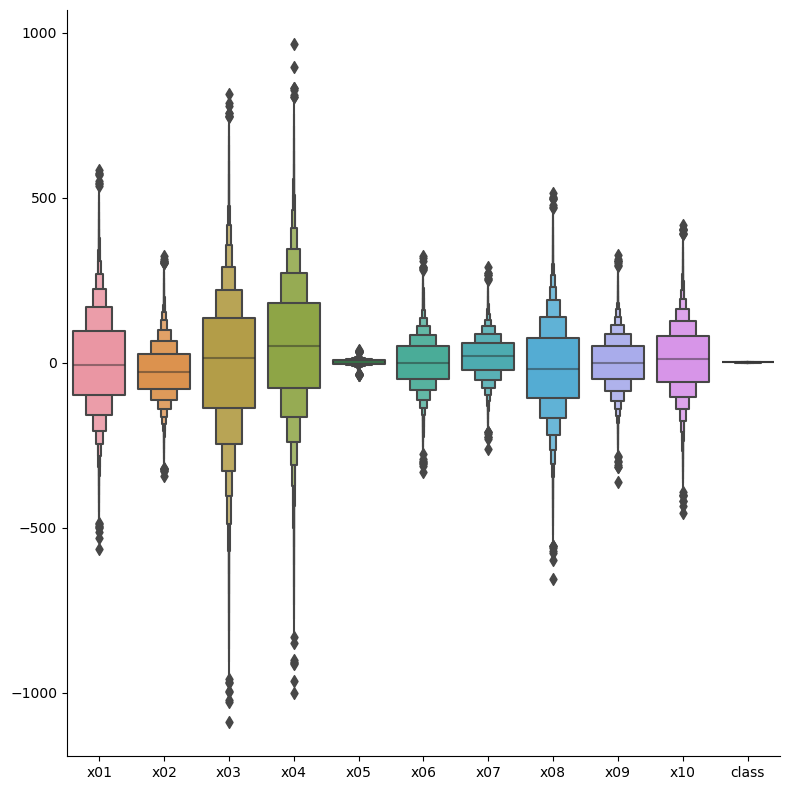

In [19]:
def show_cat_plot(df):
    sb.catplot(df, kind = 'boxen', height = 8)
    plt.show()

show_cat_plot(ds)

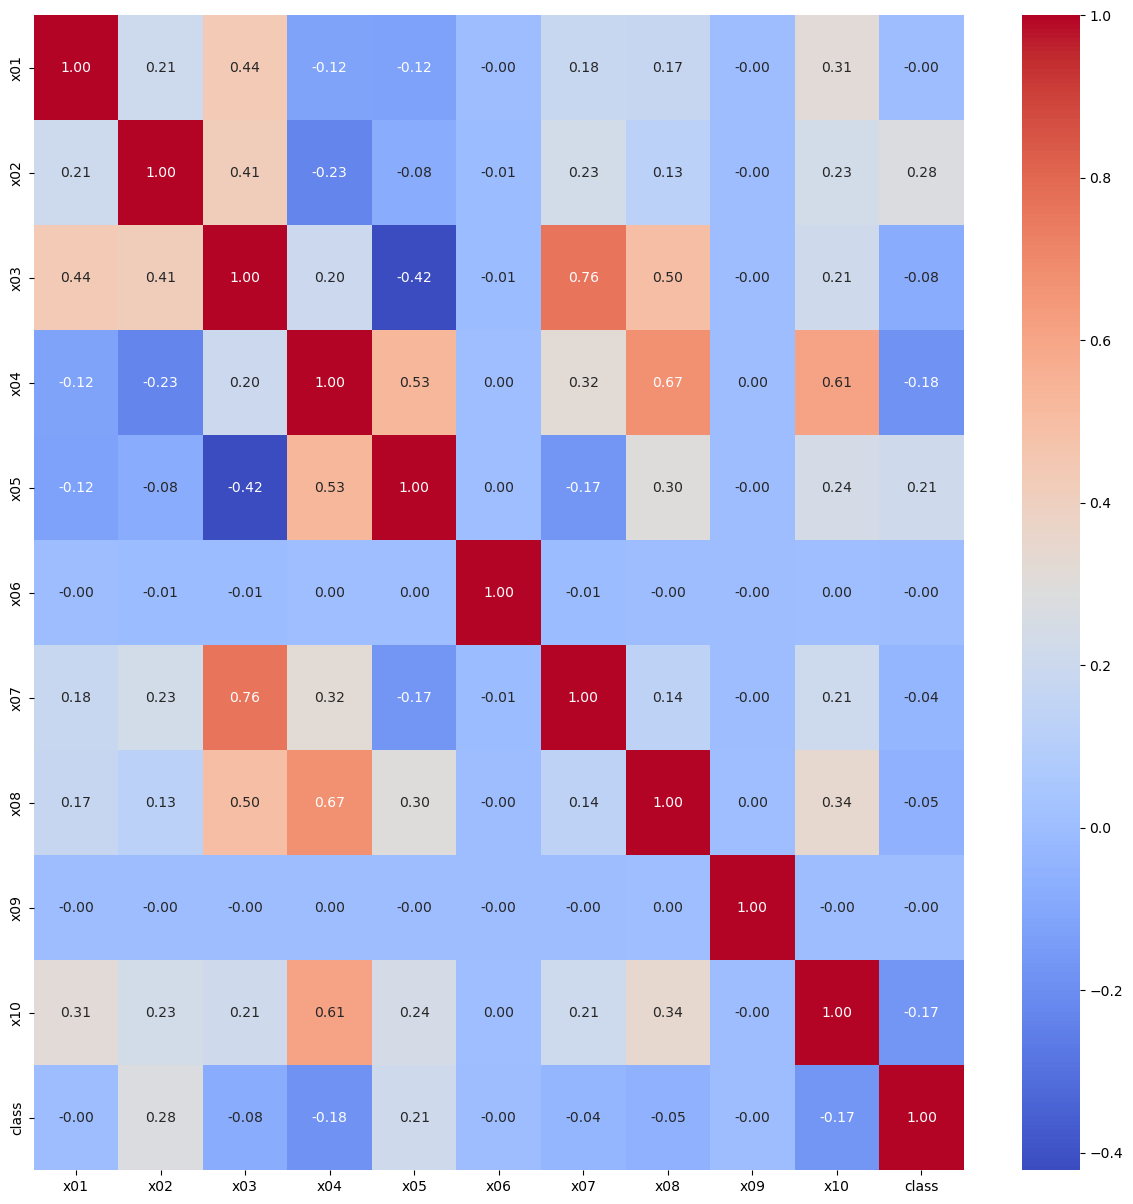

In [17]:
def show_correlation_map(df, figure_size = (15, 15)):
    plt.figure(figsize = figure_size)
    sb.heatmap(
        df.select_dtypes(exclude = ['object']).corr(),
        annot = True,
        cmap = 'coolwarm',
        fmt = '.2f')
    plt.show()

show_correlation_map(ds)

# Preprocessing

In [5]:
y = ds['class']
scaler = StandardScaler()
x = ds.drop(columns = ['class'])
x_transformed = pd.DataFrame(scaler.fit_transform(x), columns = list(x.columns))
x_transformed

x01       x02       x03       x04       x05       x06       x07  \
0       0.495963 -0.987694 -0.999139 -0.232142  0.356509 -0.839557 -0.350215   
1      -1.196316  0.183294 -1.171157 -0.477074 -0.129311 -0.586092 -1.765821   
2       0.093386 -0.892032 -0.050887  0.880879 -0.254633 -0.668533 -0.487028   
3      -0.161076 -1.009654  0.386981 -0.480272 -1.380609 -0.305995  0.232812   
4      -0.347003  0.875767  0.820851  0.112181  0.341832  0.144127 -0.429818   
...          ...       ...       ...       ...       ...       ...       ...   
119995  0.491385  1.199706 -0.194452 -1.249713 -0.988720 -0.431448 -0.944777   
119996 -0.407345  0.651755 -1.209236  0.277244  0.518992  0.433720 -2.020997   
119997 -0.087755 -0.543557 -0.261085 -1.544469 -1.218942  0.443540 -0.577782   
119998 -0.523743 -1.695396 -1.190736 -0.413149 -0.369127  0.990091  0.023372   
119999 -0.892806  0.128644  0.504958 -1.069626 -1.717042  0.731443  0.214690   

             x08       x09       x10  
0      -1.087645  2.094911  0.152493  
1      -0.109424 -0.663071 -0.177028  
2       0.610599 -1.405363  0.963527  
3      -0.401977 -0.058285 -0.942074  
4       2.020323  0.558399 -1.135920  
...          ...       ...       ...  
119995 -0.642032  0.784373  0.515118  
119996  0.443198  1.781915  1.495294  
119997 -0.914156 -1.204052 -1.697269  
119998 -1.967828  0.671014 -0.420922  
119999 -0.590483  1.436812 -1.281656  

[120000 rows x 10 columns]

# Dataset split

In [6]:
from sklearn.model_selection import train_test_split

x_train_, x_test, y_train_, y_test = train_test_split(x_transformed, y, test_size = 0.25, random_state = 42, shuffle = True)
x_train, x_validation, y_train, y_validation = train_test_split(x_train_, y_train_, test_size = 0.1, random_state = 42)

print(f'x train: {x_train.shape}')
print(f'y train: {y_train.shape}')
print()
print(f'x test: {x_test.shape}')
print(f'y test: {y_test.shape}')
print()
print(f'x validation: {x_validation.shape}')
print(f'y validation: {y_validation.shape}')

x train: (81000, 10)
y train: (81000,)

x test: (30000, 10)
y test: (30000,)

x validation: (9000, 10)
y validation: (9000,)


# Cross-validation

## Non-ensemble methods

LR: mean - 0.5288166666666667; std - 0.0016119346554167122
KNN: mean - 0.8993666666666666; std - 0.002490872225635935
GNB: mean - 0.580925; std - 0.0040060197758429155


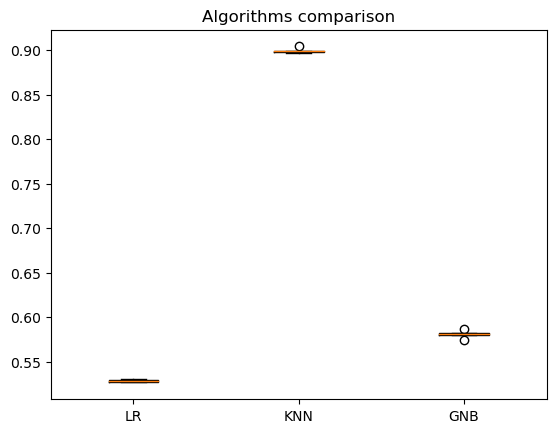

In [8]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

models = []
models.append(('LR', LogisticRegression(random_state = 42, n_jobs = -1)))
models.append(('KNN', KNeighborsClassifier(n_neighbors = 20, n_jobs = -1)))
models.append(('GNB', GaussianNB()))

results = []
names = []
for name, model in models:
    kfold = StratifiedKFold(n_splits = 5, random_state = 42, shuffle = True)
    cv_results = cross_val_score(model, x_transformed, y, cv = kfold, scoring = 'accuracy')
    results.append(cv_results)
    names.append(name)
    print(f'{name}: mean - {cv_results.mean()}; std - {cv_results.std()}')
plt.boxplot(results, labels = names)
plt.title('Algorithms comparison')
plt.show()

## Ensemble methods

CART: mean - 0.8634333333333334; std - 0.001656762237350654
RF: mean - 0.9314583333333333; std - 0.0016042478334444051
XT: mean - 0.9321250000000001; std - 0.0018274526897661069
BG: mean - 0.9113833333333332; std - 0.00172348967698291
ADA: mean - 0.5674666666666666; std - 0.004469604133601867
HG: mean - 0.9177833333333334; std - 0.0021472527667800428
XGB: mean - 0.9247; std - 0.001761352069039888
CAT: mean - 0.9296333333333333; std - 0.0017867957042955213


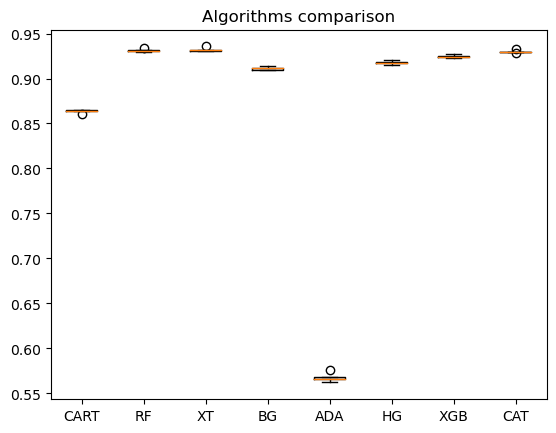

In [9]:
models = []
models.append(('CART', DecisionTreeClassifier(random_state = 42)))
models.append(('RF', RandomForestClassifier(n_jobs = -1, random_state = 42)))
models.append(('XT', ExtraTreesClassifier(n_jobs = -1, random_state = 42)))
models.append(('BG', BaggingClassifier(n_jobs = -1, random_state = 42)))
models.append(('ADA', AdaBoostClassifier(random_state = 42)))
models.append(('HG', HistGradientBoostingClassifier(random_state = 42)))
models.append(('XGB', XGBClassifier(tree_method = 'gpu_hist', verbosity = 0, random_state = 42)))
models.append(('CAT', CatBoostClassifier(
    random_seed = 42,
    loss_function = 'MultiClass',
    eval_metric = 'Accuracy',
    od_type = 'Iter',
    od_wait = 20,
    task_type = 'GPU',
    logging_level = 'Silent')))

results = []
names = []
for name, model in models:
    kfold = StratifiedKFold(n_splits = 5, random_state = 42, shuffle = True)
    cv_results = cross_val_score(model, x_transformed, y, cv = kfold, scoring = 'accuracy')
    results.append(cv_results)
    names.append(name)
    print(f'{name}: mean - {cv_results.mean()}; std - {cv_results.std()}')
plt.boxplot(results, labels = names)
plt.title('Algorithms comparison')
plt.show()

# Grid search for Random Forest classifier

Fitting 10 folds for each of 9 candidates, totalling 90 fits
Best parameters: {'max_depth': 20, 'n_estimators': 500}
              precision    recall  f1-score   support

           0       0.93      0.91      0.92      5838
           1       0.93      0.92      0.93      8991
           2       0.91      0.94      0.93      6978
           3       0.94      0.94      0.94      8193

    accuracy                           0.93     30000
   macro avg       0.93      0.93      0.93     30000
weighted avg       0.93      0.93      0.93     30000



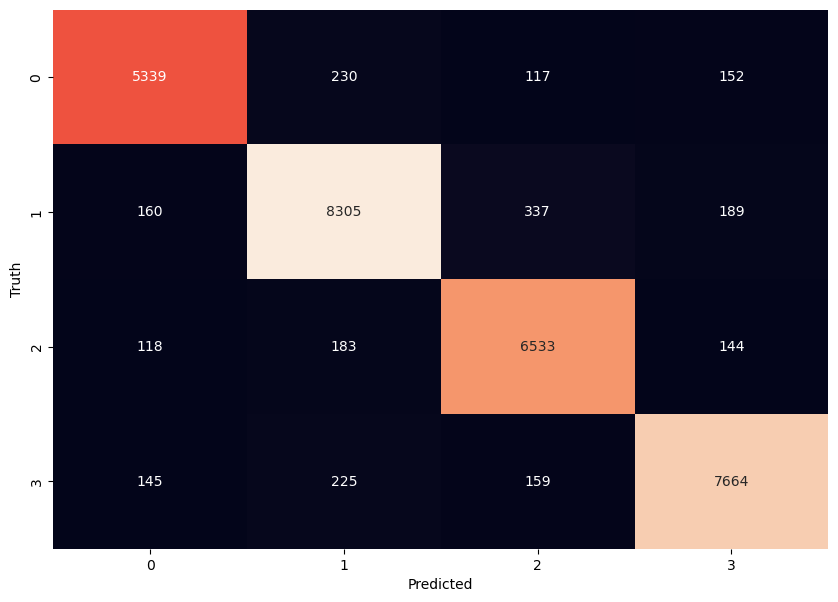

In [13]:
from sklearn.model_selection import GridSearchCV

parameters = {
    'n_estimators': [100, 200, 500],
    'max_depth': [5, 10, 20]
}

clf = RandomForestClassifier(random_state = 42, n_jobs = -1)
clf.fit(x_train, y_train)
gs = GridSearchCV(estimator = clf, cv = 10, param_grid = parameters, n_jobs = -1, verbose = 4)     
gs.fit(x_train, y_train)

print(f'Best parameters: {gs.best_params_}')
clf.set_params(**gs.best_params_)

y_pred = clf.predict(x_test)
print(classification_report(y_test, y_pred))
show_confusion_matrix(y_test, y_pred)

# Multilayer perceptron

In [30]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import Input
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout, Conv2D, BatchNormalization, ReLU
from keras.layers import MaxPooling2D, AveragePooling2D, GlobalMaxPooling2D, GlobalAveragePooling2D
# Image preprocessing
from keras.layers import Rescaling, Resizing, CenterCrop
# Image augmentation
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import RandomCrop, RandomFlip, RandomTranslation, RandomRotation, RandomZoom, RandomContrast

# List of devices
tf.config.list_physical_devices()

# Plot model function
# keras.utils.plot_model(model, show_shapes = True)

# Model loading function
# model = keras.models.load_model('model.keras', compile = False)
# model.compile(loss = 'sparse_categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
# model.summary()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [9]:
from sklearn.preprocessing import LabelEncoder

labels = ['0', '1', '2', '3']
encoder = LabelEncoder()
encoder.fit(labels)
print(encoder.inverse_transform([0]))
print(encoder.classes_)

['0']
['0' '1' '2' '3']


---
Training for fold 1...
Epoch 1/8
3000/3000 [==============================] - 19s 6ms/step - loss: 0.6142 - accuracy: 0.7595
Epoch 2/8
3000/3000 [==============================] - 18s 6ms/step - loss: 0.3924 - accuracy: 0.8593
Epoch 3/8
3000/3000 [==============================] - 17s 6ms/step - loss: 0.3524 - accuracy: 0.8767
Epoch 4/8
3000/3000 [==============================] - 17s 6ms/step - loss: 0.3336 - accuracy: 0.8840
Epoch 5/8
3000/3000 [==============================] - 17s 6ms/step - loss: 0.3204 - accuracy: 0.8904
Epoch 6/8
3000/3000 [==============================] - 17s 6ms/step - loss: 0.3144 - accuracy: 0.8941
Epoch 7/8
3000/3000 [==============================] - 17s 6ms/step - loss: 0.3073 - accuracy: 0.8976
Epoch 8/8
3000/3000 [==============================] - 17s 6ms/step - loss: 0.3019 - accuracy: 0.8973
Score for fold 1: loss of 0.2090095579624176; accuracy of 93.34999918937683%


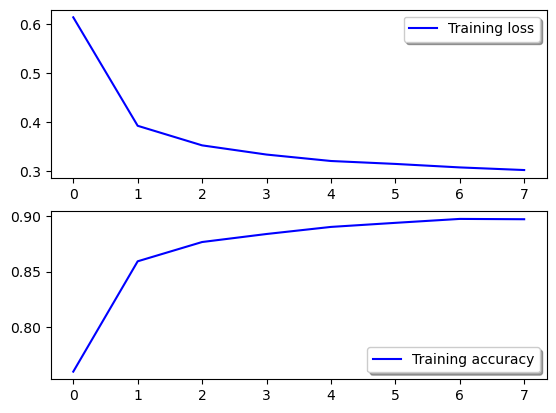

              precision    recall  f1-score   support

           0       0.93      0.92      0.92      4768
           1       0.94      0.93      0.93      7176
           2       0.92      0.95      0.93      5578
           3       0.95      0.93      0.94      6478

    accuracy                           0.93     24000
   macro avg       0.93      0.93      0.93     24000
weighted avg       0.93      0.93      0.93     24000



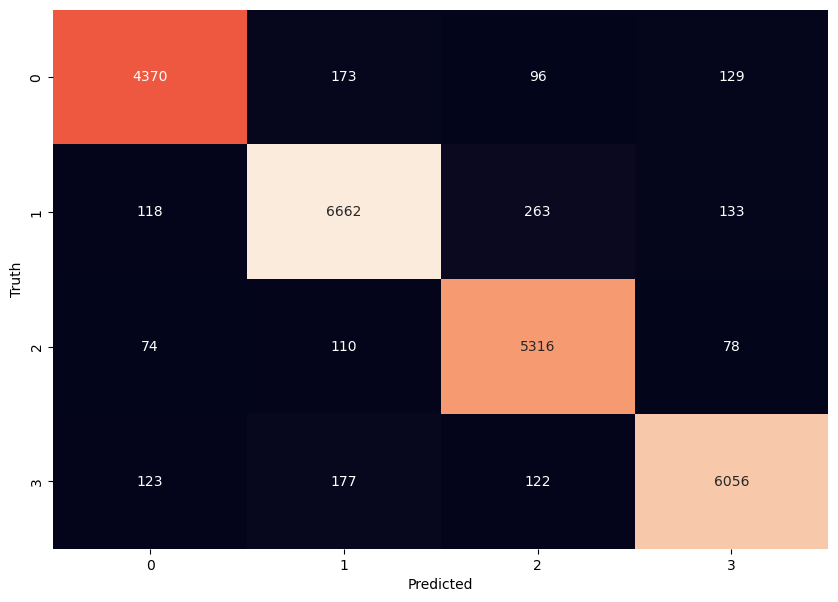

---
Training for fold 2...
Epoch 1/8
3000/3000 [==============================] - 18s 6ms/step - loss: 0.6234 - accuracy: 0.7558
Epoch 2/8
3000/3000 [==============================] - 18s 6ms/step - loss: 0.4177 - accuracy: 0.8480
Epoch 3/8
3000/3000 [==============================] - 18s 6ms/step - loss: 0.3667 - accuracy: 0.8707
Epoch 4/8
3000/3000 [==============================] - 18s 6ms/step - loss: 0.3436 - accuracy: 0.8801
Epoch 5/8
3000/3000 [==============================] - 18s 6ms/step - loss: 0.3324 - accuracy: 0.8851
Epoch 6/8
3000/3000 [==============================] - 18s 6ms/step - loss: 0.3211 - accuracy: 0.8898
Epoch 7/8
3000/3000 [==============================] - 18s 6ms/step - loss: 0.3145 - accuracy: 0.8934
Epoch 8/8
3000/3000 [==============================] - 18s 6ms/step - loss: 0.3058 - accuracy: 0.8978
Score for fold 2: loss of 0.21184177696704865; accuracy of 92.82083511352539%


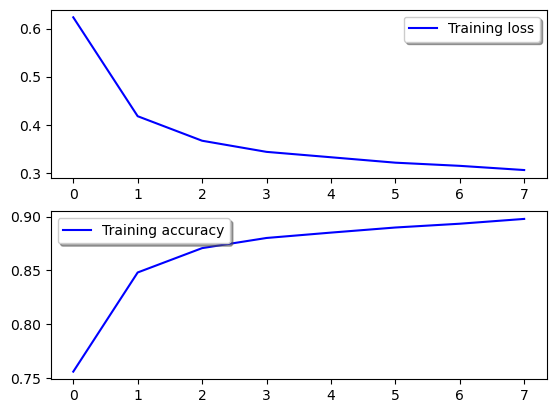

              precision    recall  f1-score   support

           0       0.93      0.92      0.92      4768
           1       0.94      0.91      0.92      7176
           2       0.91      0.95      0.93      5579
           3       0.94      0.94      0.94      6477

    accuracy                           0.93     24000
   macro avg       0.93      0.93      0.93     24000
weighted avg       0.93      0.93      0.93     24000



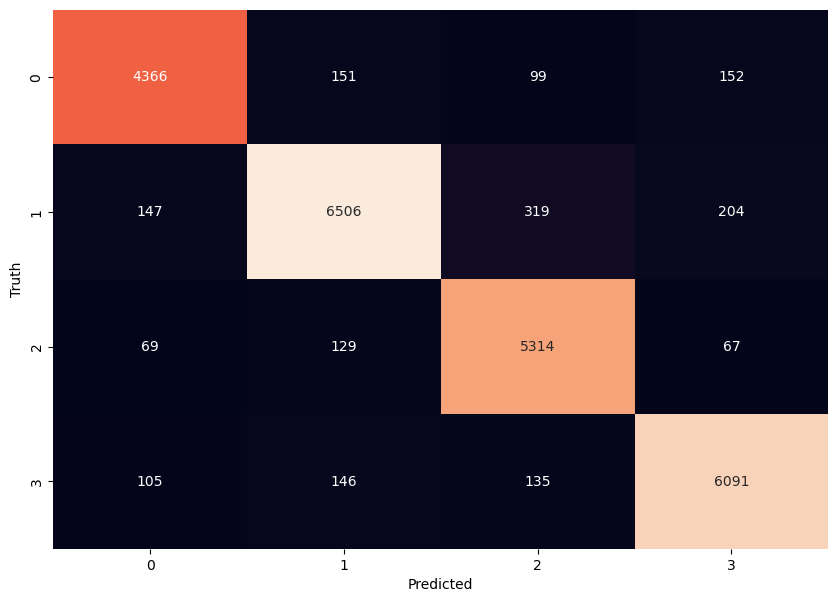

---
Training for fold 3...
Epoch 1/8
3000/3000 [==============================] - 18s 6ms/step - loss: 0.6333 - accuracy: 0.7488
Epoch 2/8
3000/3000 [==============================] - 18s 6ms/step - loss: 0.4084 - accuracy: 0.8539
Epoch 3/8
3000/3000 [==============================] - 18s 6ms/step - loss: 0.3601 - accuracy: 0.8757
Epoch 4/8
3000/3000 [==============================] - 18s 6ms/step - loss: 0.3353 - accuracy: 0.8848
Epoch 5/8
3000/3000 [==============================] - 18s 6ms/step - loss: 0.3253 - accuracy: 0.8889
Epoch 6/8
3000/3000 [==============================] - 18s 6ms/step - loss: 0.3164 - accuracy: 0.8929
Epoch 7/8
3000/3000 [==============================] - 18s 6ms/step - loss: 0.3062 - accuracy: 0.8969
Epoch 8/8
3000/3000 [==============================] - 18s 6ms/step - loss: 0.3046 - accuracy: 0.8981
Score for fold 3: loss of 0.2124621719121933; accuracy of 92.80833601951599%


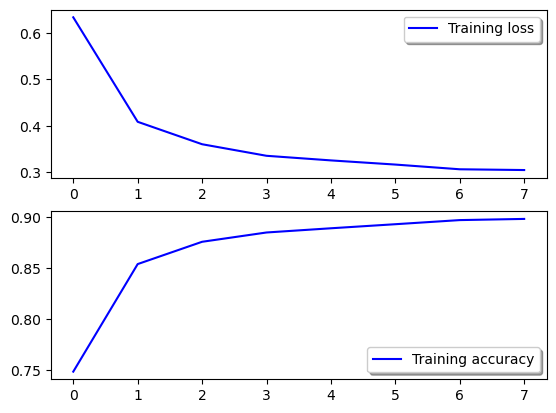

              precision    recall  f1-score   support

           0       0.92      0.91      0.92      4768
           1       0.93      0.92      0.93      7176
           2       0.92      0.94      0.93      5579
           3       0.94      0.94      0.94      6477

    accuracy                           0.93     24000
   macro avg       0.93      0.93      0.93     24000
weighted avg       0.93      0.93      0.93     24000



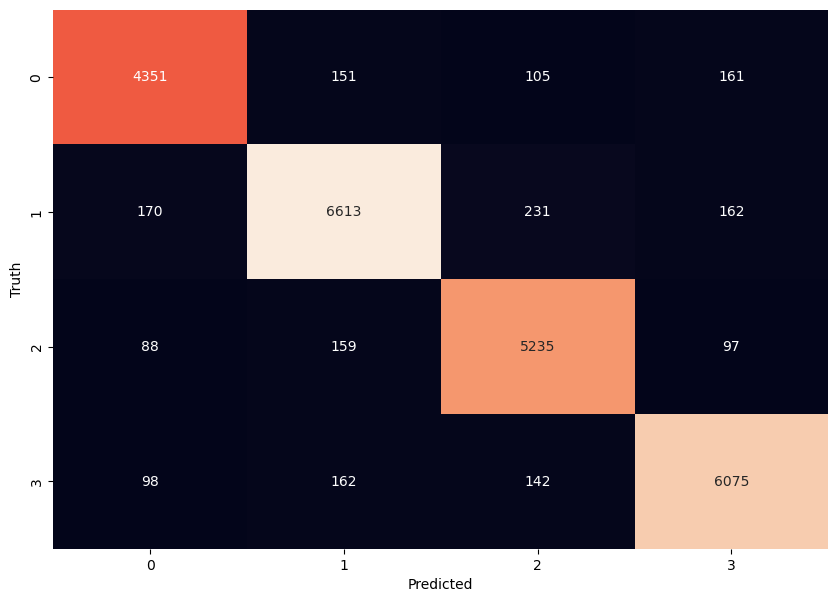

---
Training for fold 4...
Epoch 1/8
3000/3000 [==============================] - 18s 6ms/step - loss: 0.6175 - accuracy: 0.7578
Epoch 2/8
3000/3000 [==============================] - 17s 6ms/step - loss: 0.4094 - accuracy: 0.8517
Epoch 3/8
3000/3000 [==============================] - 18s 6ms/step - loss: 0.3600 - accuracy: 0.8733
Epoch 4/8
3000/3000 [==============================] - 17s 6ms/step - loss: 0.3360 - accuracy: 0.8830
Epoch 5/8
3000/3000 [==============================] - 17s 6ms/step - loss: 0.3248 - accuracy: 0.8886
Epoch 6/8
3000/3000 [==============================] - 18s 6ms/step - loss: 0.3169 - accuracy: 0.8916
Epoch 7/8
3000/3000 [==============================] - 18s 6ms/step - loss: 0.3089 - accuracy: 0.8950
Epoch 8/8
3000/3000 [==============================] - 17s 6ms/step - loss: 0.3031 - accuracy: 0.8971
Score for fold 4: loss of 0.21757566928863525; accuracy of 92.81666874885559%


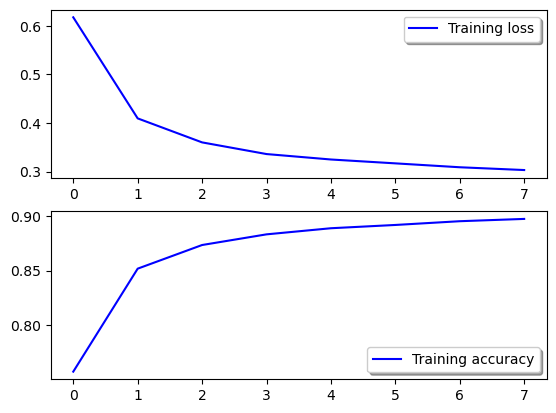

              precision    recall  f1-score   support

           0       0.92      0.92      0.92      4768
           1       0.93      0.92      0.92      7175
           2       0.91      0.95      0.93      5579
           3       0.95      0.92      0.94      6478

    accuracy                           0.93     24000
   macro avg       0.93      0.93      0.93     24000
weighted avg       0.93      0.93      0.93     24000



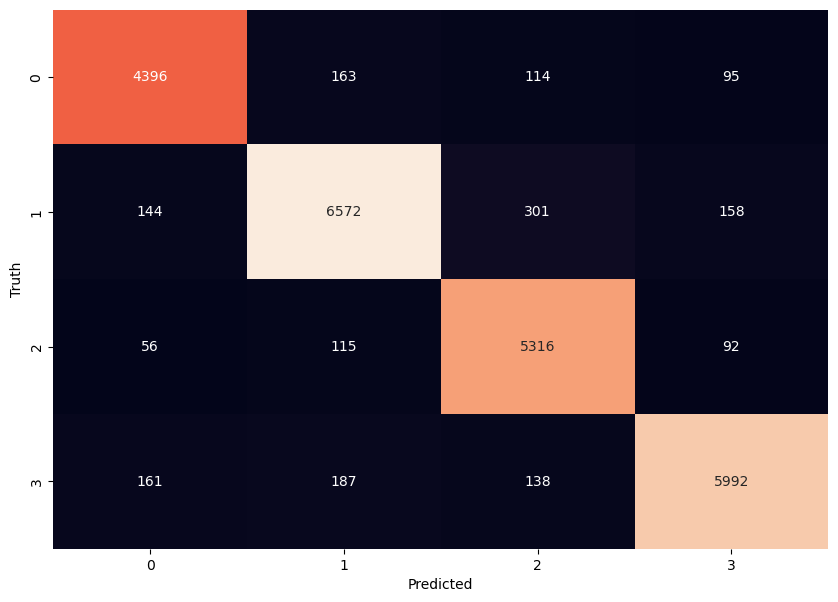

---
Training for fold 5...
Epoch 1/8
3000/3000 [==============================] - 19s 6ms/step - loss: 0.6266 - accuracy: 0.7517
Epoch 2/8
3000/3000 [==============================] - 18s 6ms/step - loss: 0.4159 - accuracy: 0.8494
Epoch 3/8
3000/3000 [==============================] - 18s 6ms/step - loss: 0.3654 - accuracy: 0.8704
Epoch 4/8
3000/3000 [==============================] - 18s 6ms/step - loss: 0.3438 - accuracy: 0.8799
Epoch 5/8
3000/3000 [==============================] - 18s 6ms/step - loss: 0.3301 - accuracy: 0.8869
Epoch 6/8
3000/3000 [==============================] - 18s 6ms/step - loss: 0.3185 - accuracy: 0.8905
Epoch 7/8
3000/3000 [==============================] - 18s 6ms/step - loss: 0.3110 - accuracy: 0.8951
Epoch 8/8
3000/3000 [==============================] - 18s 6ms/step - loss: 0.3037 - accuracy: 0.8969
Score for fold 5: loss of 0.21034637093544006; accuracy of 93.17916631698608%


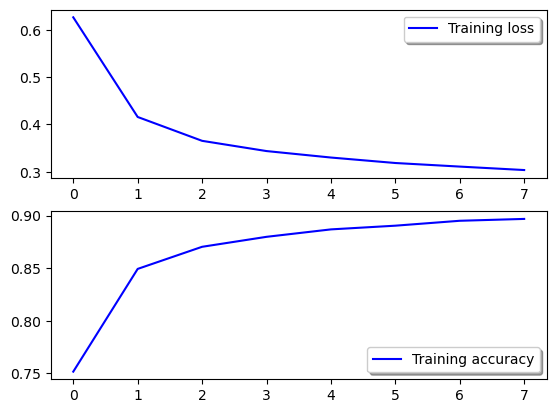

              precision    recall  f1-score   support

           0       0.92      0.93      0.93      4767
           1       0.93      0.93      0.93      7176
           2       0.91      0.95      0.93      5579
           3       0.96      0.92      0.94      6478

    accuracy                           0.93     24000
   macro avg       0.93      0.93      0.93     24000
weighted avg       0.93      0.93      0.93     24000



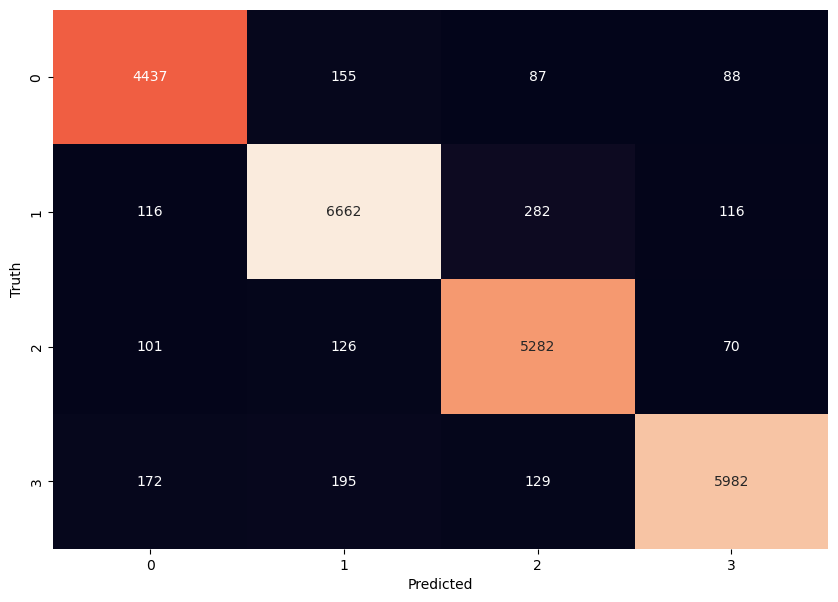

---
Score per fold
---
> Fold 1 - Loss: 0.2090095579624176 - Accuracy: 93.34999918937683%
---
> Fold 2 - Loss: 0.21184177696704865 - Accuracy: 92.82083511352539%
---
> Fold 3 - Loss: 0.2124621719121933 - Accuracy: 92.80833601951599%
---
> Fold 4 - Loss: 0.21757566928863525 - Accuracy: 92.81666874885559%
---
> Fold 5 - Loss: 0.21034637093544006 - Accuracy: 93.17916631698608%
---
Average scores for all folds:
> Accuracy: 92.99500107765198 (+- 0.2266806304871228)
> Loss: 0.21224710941314698
---


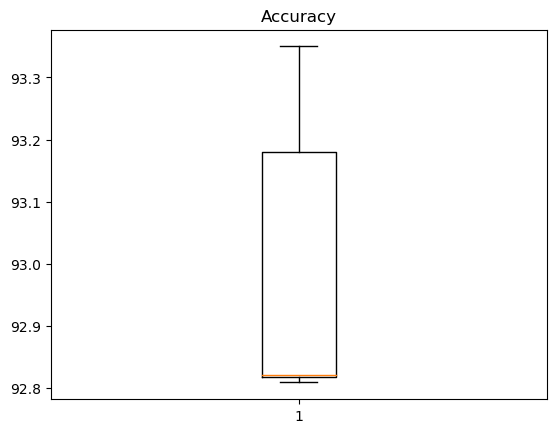

In [37]:
from sklearn.model_selection import StratifiedKFold, cross_val_score

batch_size = 32
epochs = 8
num_folds = 5
acc_per_fold = []
loss_per_fold = []
histories = []
kfold = StratifiedKFold(n_splits = num_folds, random_state = 42, shuffle = True)
fold_no = 1
for train, test in kfold.split(x_transformed, y):
    model = Sequential(
    [
        Input(shape = x_train.shape[1]),
        Dense(50, activation = 'relu'),
        Dropout(0.20),
        Dense(50, activation = 'relu'),
        Dropout(0.25),
        Dense(50, activation = 'relu'),
        Dropout(0.3),
        Dense(4, activation = 'softmax')
    ])
    model.compile(loss = 'sparse_categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
    print('---')
    print(f'Training for fold {fold_no}...')
    history = model.fit(
        x = x_transformed.iloc[train],
        y = y[train],
        batch_size = batch_size,
        epochs = epochs)
    histories.append(history)
    scores = model.evaluate(x_transformed.iloc[test], y[test], verbose = 0)
    print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1] * 100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])
    show_training_history(history)
    y_pred = np.argmax(model.predict(x_transformed.iloc[test], verbose = 0), axis = 1)
    print(classification_report(
        encoder.inverse_transform(y[test]),
        encoder.inverse_transform(y_pred)))
    show_confusion_matrix(y[test], y_pred, labels)
    fold_no = fold_no + 1
print('---')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
    print('---')
    print(f'> Fold {i + 1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('---')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('---')
plt.boxplot(acc_per_fold)
plt.title('Accuracy')
plt.show()